> Yazeed Alobaidan

# Introduction

Arabic text classification and generation have become increasingly important in natural language processing (NLP) due to the demand for AI applications in the Arabic world. Arabic presents unique challenges, such as complex morphology, rich inflection, and diverse dialects. Classification tasks involve categorizing text into predefined categories.

On the other hand, text generation aims to produce coherent and contextually relevant Arabic text, which can enhance translation systems, and content creation tools. Leveraging models like BERT tailored for Arabic, which can effectively address these tasks, advancing NLP capabilities in the Arabic language.

# Corpus

for this project I used, the [KALIMAT Multipurpose Arabic Corpus](https://sourceforge.net/projects/kalimat/), containing articles across six topics (culture, economy,
local news, international news, religion, sports) from the Alwatan newspaper. distributed as follows:


*   Culture: 2495 documents


*   Economy: 3265 documents



*   International: 1689 documents


*   Local: 3237 documents


*   Religion: 3475 documents


*   Sports: 4095 documents



In [ ]:
! pip install rouge

In [ ]:
# imports
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModel
import unicodedata
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW
from torch.optim import SparseAdam, Adam
import random
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from transformers import BertTokenizer, BertForMaskedLM
from torch.utils.data import Dataset
import shutil
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu


In [ ]:
# I want to check my tensorflow and keras version

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)


2.17.1
3.5.0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/MyDrive/Datasets/KALIMAT.zip"

Streaming output truncated to the last 5000 lines.
  inflating: KALIMAT/articlesReligion/religioncmay734.txt  
  inflating: KALIMAT/articlesReligion/religioncmay735.txt  
  inflating: KALIMAT/articlesReligion/religioncmay736.txt  
  inflating: KALIMAT/articlesReligion/religioncmay737.txt  
  inflating: KALIMAT/articlesReligion/religioncmay738.txt  
  inflating: KALIMAT/articlesReligion/religioncmay739.txt  
  inflating: KALIMAT/articlesReligion/religioncmay740.txt  
  inflating: KALIMAT/articlesReligion/religioncmay741.txt  
  inflating: KALIMAT/articlesReligion/religioncmay794.txt  
  inflating: KALIMAT/articlesReligion/religioncmay795.txt  
  inflating: KALIMAT/articlesReligion/religioncmay796.txt  
  inflating: KALIMAT/articlesReligion/religioncmay797.txt  
  inflating: KALIMAT/articlesReligion/religioncmay798.txt  
  inflating: KALIMAT/articlesReligion/religioncmay799.txt  
  inflating: KALIMAT/articlesReligion/religioncmay800.txt  
  inflating: KALIMAT/articlesReligion/religioncma

let's load the documents to 3 variables:
 * texts
 * labels
 * class names

In [ ]:
def load_data_from_directories(base_path):
    texts = []
    labels = []
    class_names = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    label_to_index = {label: idx for idx, label in enumerate(class_names)}

    for label in class_names:
        folder_path = os.path.join(base_path, label)
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()

                    texts.append(text)
                    labels.append(label_to_index[label])
    return texts, labels, class_names

base_path = '/content/KALIMAT'
texts, labels, class_names = load_data_from_directories(base_path)

plotting the count of each class

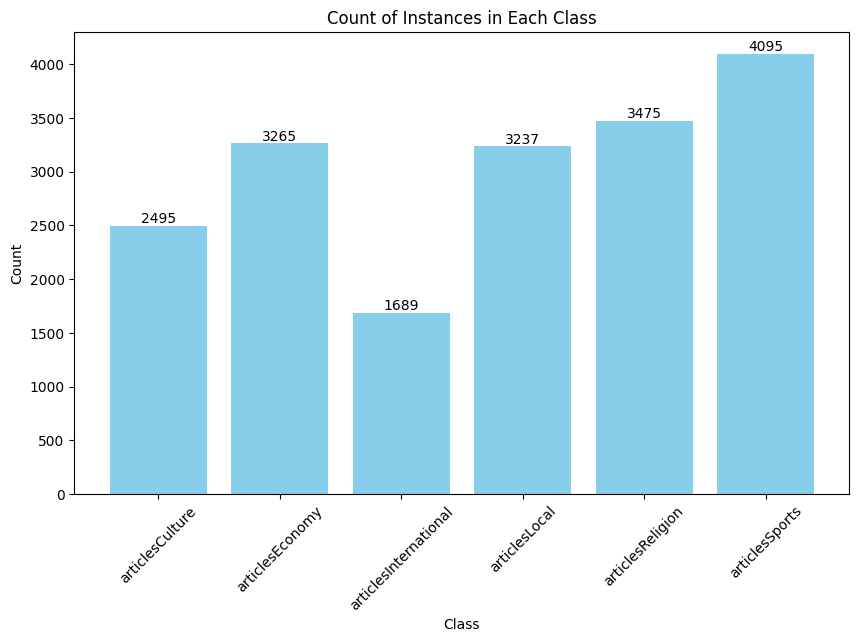

In [ ]:

# Count each class in labels
label_counts = Counter(labels)

# Plotting bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar([class_names[i] for i in label_counts.keys()], label_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Count of Instances in Each Class")
plt.xticks(rotation=45)

plt.bar_label(bars)

plt.show()

showcasing an example of a document

In [ ]:
texts[2]

'ظهر\nالمسرح\nالعمالي\nفي\nالفترة\nمن\n1880\nالى\n1935\nفي\nبريطانيا\nوأميركا\nويقوم\nعلى\nتأييد\nالفكر\nالسياسي\nوالاجتماعي\nالعمالي\nأيا\nكانت\nدوافعه\n.\nاما\nعن\nاهم\nرواده\nفكانوا\nمن\nمؤيدي\nالحركة\nالعمالية\nفي\nتلك\nالفترة\nلذا\nفقد\nكانت\nمادته\nمن\nالوثائق\nالسياسية\nوالمذكرات\nوالخطابات\nوالتوصيات\nذات\nالصوت\nالجماعي\nوالتي\nتؤكد\nمطالب\nالحركة\nالعمالية\nوحقوقها\nبالاضافة\nالى\nالتنديد\nبالعنصرية\nوالفروق\nالفردية\nومن\nمنطلق\nذلك\nكان\nلا\nبد\nان\nتطغى\nعليه\nروح\nالجماعة\nحيث\nتم\nاستبدال\nالبطولة\nالفردية\nبالمشاركة\nالجماعية\n.\nوقدمت\nتلك\nالعروض\nفي\nأماكن\nالتجمعات\nالعمالية\nومسارح\nالأندية\nوالمكتبات\nالعامة\n.\nرافايل\nصامويل\nوالمسرح\nالعمالي\nقام\n(\nرافايل\nصامويل\n)\nبالتوثيق\nللمسرح\nالعمالي\nفي\nمقدمة\nكتابه\n(\nاتجاهات\nالمسرح\nالعمالي\n)\nويتضمن\nهذا\nالكتاب\nشرحا\nتفصيليا\nعن\nتاريخ\nالحركات\nالمسرحية\nالعمالية\nفي\nبريطانيا\nواميركا\n.\nويستهل\n(\nرافايل\nصامويل\n)\nكتابه\nبمقدمة\nاكد\nفيها\nان\nالمسرح\nوالسياسة\nوجهان\nلعملة\nواحدة\nوهو\nالمحرك\nالأول\

# Preprocess the texts

In [ ]:

def preprocess_text(text):
    # Normalize text
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ى', 'ي', text)
    text= re.sub(r'\n', " ",text)
    text= re.sub(r'  ', " ",text)
    text= re.sub(r'[^\w\s]', ' ', text)


    # Return the normalized text
    return text


preprocessed_texts = [preprocess_text(text) for text in texts]


showcasing a preprocessed text

In [ ]:
preprocessed_texts[45]

'مقاربات كتب من صاله المعرض الي معرض الصاله بفارغ اللهفه والشوق ننتظر الاعلان عن موعد اقامه معرض الكتاب الذي لا يتكرر الا مره واحده في العام الواحد وما ان يتم الاعلان عنه حتي يصبح الشغل الشاغل والحدث الاهم والابرز لدي وسائل الاعلام وعند المثقفين ومحبي الاطلاع الذين يجدون فيه ملاذا لارواحهم وذائقتهم التي تستهويها مشاهد الكتب ورائحه الاوراق   ومنذ الوهله الاولي التي يفتح المعرض فيها ابوابه للزوار تبدا الاعداد الغفيره من الجماهير بالتدافع والتزاحم في اروقته العريضه كل ينشد عنوانا مختلفا ويسال عن كتاب ما بل ان البعض يشتري كل ما يثير فضوله بشكل او اخر دون وعي او درايه لما يحتوي عليه الكتاب من مضمون بين دفتيه ولعل هذا الزائر للمعرض قد اشتري ذلك الكتاب بتوصيه من صديق او سمع عنه في حديث عابر فقرر اقتناءه   تدهشك جدا مناظر الاعداد الكبيره المتجمهره من الناس القادمه الي المعرض بلهفه ووله والخارجه منه محمله بالاوزان الثقيله من المشتريات التي جلبها من المعرض بعد عناء وتجوال وبحث طويل فتعتريك للوهله الاولي مشاعر الفرح والاستبشار بما تراه ويسر به ناظرك ويرتاح قلبك حيث يتبدي لك ان العلاقه بين الناس و

splitting the data to 80/20

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(preprocessed_texts, labels, test_size=0.2, random_state=42, shuffle = True)

Device Setup


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA L4


# Text Classification

defining the tokenizer, using asafaya

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERT preprocessing for Arabic Text

In [ ]:
def preprocessing_for_bert(data ):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []


    # For every sentence...
    for i,sent in enumerate(data):
        encoded_sent = tokenizer.encode_plus(
            text=preprocess_text(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            return_attention_mask=True,     # Return attention mask
            truncation = True
            )

        # Add the results to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

run the function for the train, and valid data

In [ ]:

MAX_LEN =  512


# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = preprocessing_for_bert(x_train)
val_inputs, val_masks = preprocessing_for_bert(x_test)

Prepare data for BERT model

In [ ]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# batch_size
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Define BERT classifier model

In [ ]:

# Create the BertClassfier class
class BertClassifier(nn.Module):
    #Bert Model for Classification Tasks.

    def __init__(self):
        super(BertClassifier, self).__init__()

        # Instantiate BERT model
        self.bert =  AutoModel.from_pretrained("asafaya/bert-base-arabic")
        # Instantiater feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 6)
        )


    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Training the BERT Model

In [ ]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()
def train(model, train_dataloader, val_dataloader, epochs):


     # Training


    print("Start training...\n")
    for epoch_i in range(epochs):



        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")


        # Measure the elapsed time of each epoch
        t0_epoch = time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss = 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters and the learning rate
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)


        #Evaluation

        val_loss, val_accuracy = evaluate(model, val_dataloader)

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch

        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("-"*70)
        print("\n")

    print("Training complete!")



 Model Evaluation function

In [ ]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy




initialize the BERT model

In [ ]:
# Instantiate Bert Classifier
bert_classifier2 = BertClassifier()
# run the model on GPU
bert_classifier2.to(device)

# Create the optimizer
optimizer = AdamW(params=list(bert_classifier2.parameters()),
                  lr=1e-5)

Model Training Execution

In [ ]:
train(bert_classifier2, train_dataloader, val_dataloader, epochs=5)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.374323   |  0.196289  |   93.78   |  634.15  
----------------------------------------------------------------------


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.160214   |  0.195256  |   93.34   |  635.62  
----------------------------------------------------------------------


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.109974   |  0.210517  |   93.04   |  635.71  
----------------------------------------------------------------------


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   4    |    -    |   0.0719

Save Model to the drive

In [ ]:
tokenizer.save_pretrained("./BERTCLassification12")
torch.save(bert_classifier2, "/content/drive/MyDrive/BERTClassifier_complete.pth")

In [ ]:
# Source file path
source_path = '/content/BERTCLassification12'

# Destination path
destination_path = '/content/drive/MyDrive/BERTCLassification_finalll12'

# Move the file
shutil.move(source_path, destination_path)

print("File moved to Google Drive!")

File moved to Google Drive!


## Results

In [ ]:
# Put the model in evaluation mode
bert_classifier2.eval()

all_labels = []
all_preds = []

# Disable gradient calculation
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch[0]  # input_ids
        attention_mask = batch[1]  # attention_mask
        labels = batch[2]  # labels

        # Move tensors to the appropriate GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = bert_classifier2(input_ids=input_ids, attention_mask=attention_mask)  # Directly returns logits

        # Get the predicted class (argmax of the logits)
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy, precision, recall, f1-score, and confusion matrix
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.940854326396495
Precision: 0.941844752047339
Recall: 0.940854326396495
F1-score: 0.9410551432674338
Confusion Matrix:
[[443   2   3  26   5   1]
 [  4 573   9  71   0   1]
 [  1   4 315   2   0   1]
 [  9  53   0 627   5   3]
 [  1   0   0   0 680   0]
 [  1   0   0  14   0 798]]


Confusion Matrix!

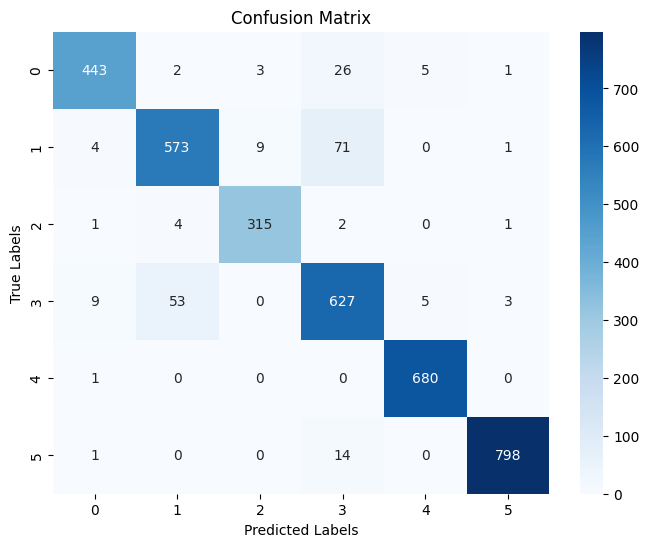

In [ ]:
# Plotting the Confusion Matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Text Generation

Define the model for mlm

In [ ]:
# Load pre-trained BERT for MLM
model = BertForMaskedLM.from_pretrained('asafaya/bert-base-arabic')

model.to(device)

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Create a dataset for our mlm model

In [ ]:
class MLMDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512, mask_probability=0.15):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_probability = mask_probability

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenize input
        encoding = tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt', add_special_tokens=True)

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Mask tokens
        labels = input_ids.clone()
        rand = torch.rand(input_ids.shape)
        mask_arr = (rand < self.mask_probability) * (input_ids != tokenizer.cls_token_id) * (input_ids != tokenizer.sep_token_id) * (input_ids != tokenizer.pad_token_id)

        selection = torch.flatten(mask_arr.nonzero()).tolist()
        input_ids[selection] = tokenizer.mask_token_id

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

create a dataset for both training and validation, then initalize the Dataloader

In [ ]:
train_dataset = MLMDataset(x_train, tokenizer)
val_dataset = MLMDataset(x_test, tokenizer)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)


optimizer and epochs

In [ ]:
# Set up optimizer and epochs
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 5

Training!

In [ ]:
# Training Loop
for epoch in range(epochs):
    model.train()

    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss}")

    # Evaluation
    model.eval()
    val_loss = 0
    for batch in val_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")


Epoch 1, Loss: 0.007954455068994667
Epoch 1, Validation Loss: 9.010760968760231e-05
Epoch 2, Loss: 0.00018969700964173325
Epoch 2, Validation Loss: 2.245247088669846e-05
Epoch 3, Loss: 7.923782522734859e-05
Epoch 3, Validation Loss: 1.097507650360153e-05
Epoch 4, Loss: 4.4817264309401095e-05
Epoch 4, Validation Loss: 6.814944366073273e-06
Epoch 5, Loss: 5.685384208748166e-05
Epoch 5, Validation Loss: 5.92841146058421e-06


let's save the model!

In [ ]:

# Save the fine-tuned model
model.save_pretrained("./mlm_finetuned1_model")
tokenizer.save_pretrained("./mlm_finetuned1_model")

('./mlm_finetuned1_model/tokenizer_config.json',
 './mlm_finetuned1_model/special_tokens_map.json',
 './mlm_finetuned1_model/vocab.txt',
 './mlm_finetuned1_model/added_tokens.json',
 './mlm_finetuned1_model/tokenizer.json')

In [ ]:
# Source file path
source_path = '/content/mlm_finetuned1_model'

# Destination path
destination_path = '/content/drive/MyDrive/mlm_finetuned12_model'

# Move the file
shutil.move(source_path, destination_path)

print("File moved to Google Drive!")

File moved to Google Drive!


Defining the text generation function using the model

In [ ]:
# Load the fine-tuned model and tokenizer
model = BertForMaskedLM.from_pretrained('/content/drive/MyDrive/mlm_finetuned12_model')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/mlm_finetuned12_model')

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def predict_next_words(input_ids, num_predictions):
    generated_text_ids = input_ids.clone().to(device)  # Start with initial input tensor

    for _ in range(num_predictions):
        # Check length and truncate if necessary to avoid exceeding max length
        if generated_text_ids.size(1) >= 511:
            generated_text_ids = generated_text_ids[:, :511]

        # Add [MASK] token at the end of the input
        mask_token_tensor = tokenizer.encode('[MASK]', add_special_tokens=False, return_tensors='pt').to(device)
        input_ids_with_mask = torch.cat([generated_text_ids, mask_token_tensor], dim=1)

        # Predict the masked token
        with torch.no_grad():
            outputs = model(input_ids_with_mask)
            predictions = outputs.logits

        # Get the predicted token ID for the [MASK] token
        mask_token_index = torch.where(input_ids_with_mask == tokenizer.mask_token_id)[1]
        logits = predictions[0, mask_token_index, :].squeeze(0)

        # Get the second-highest token ID
        top2_indices = logits.topk(2).indices  # Get indices of the two highest values
        second_highest_token_id = top2_indices[1]  # Select the second highest

        # Expand dimensions to match generated_text_ids
        second_highest_token_id = second_highest_token_id.unsqueeze(0).unsqueeze(0)
        generated_text_ids = torch.cat([generated_text_ids, second_highest_token_id], dim=1)

    # Decode the generated sequence
    generated_text = tokenizer.decode(generated_text_ids[0], skip_special_tokens=True)
    return generated_text



Let's Infer!

In [ ]:
# Example
initial_text ="يلعب نادي تشيلسي ضد نادي بايرن ميونخ في نهائي دوري ابطال"
input_ids = tokenizer.encode(initial_text, return_tensors="pt").to(device)  # Tokenize input text to tensor
completed_text = predict_next_words(input_ids, num_predictions=10)

print("Final generated text:\n", completed_text)


Final generated text:
 يلعب نادي تشيلسي ضد نادي بايرن ميونخ في نهايي دوري ابطال في ميونخ من قبل الفيفا في المانيا من خلال الاتحاد


## Results

BLEU score

In [ ]:
tokenized_texts = [tokenizer(text, max_length=512, truncation=True, return_tensors="pt") for text in x_test]


In [ ]:
generated_texts = [predict_next_words(tokenized_text['input_ids'], num_predictions=10) for tokenized_text in tokenized_texts]

reference_texts = [[text.split()] for text in x_test]  # Tokenize each reference text

# Calculate BLEU score for each generated text
bleu_scores = [sentence_bleu(ref, gen.split()) for ref, gen in zip(reference_texts, generated_texts)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu_score}")


Average BLEU Score: 0.7046627890382958


Rouge scores

In [ ]:
rouge = Rouge()

MAX_LENGTH = 512

# Function to truncate text to a maximum length
def truncate_text(text, max_length=MAX_LENGTH):
    return ' '.join(text.split()[:max_length])

# Truncate each generated and reference text
truncated_generated_texts = [truncate_text(text) for text in generated_texts]
truncated_reference_texts = [truncate_text(text) for text in x_test]

# Calculate ROUGE scores for each pair and store them
rouge1_f, rouge2_f, rougeL_f = [], [], []

# Loop through each pair of truncated generated and reference text
for gen, ref in zip(truncated_generated_texts, truncated_reference_texts):
    scores = rouge.get_scores(gen, ref)

    # Extract F1 scores for ROUGE-1, ROUGE-2, and ROUGE-L
    rouge1_f.append(scores[0]['rouge-1']['f'])
    rouge2_f.append(scores[0]['rouge-2']['f'])
    rougeL_f.append(scores[0]['rouge-l']['f'])

# Calculate the average ROUGE F1 scores
average_rouge1 = sum(rouge1_f) / len(rouge1_f)
average_rouge2 = sum(rouge2_f) / len(rouge2_f)
average_rougeL = sum(rougeL_f) / len(rougeL_f)

# Display the results
print(f"Average ROUGE-1 F1: {average_rouge1}")
print(f"Average ROUGE-2 F1: {average_rouge2}")
print(f"Average ROUGE-L F1: {average_rougeL}")

Average ROUGE-1 F1: 0.9206387363586105
Average ROUGE-2 F1: 0.8914805799290905
Average ROUGE-L F1: 0.9206368179161838


# Conclusion

* This project implemented an Arabic text classification and generation system using BERT-based models.
* The classification model achieved high performance with:
 1. Accuracy: 94%
 2. F1 Score: 94%


* showing BERT’s effectiveness in Arabic classification tasks.


* For text generation, the fine-tuned BERT model achieved:
 1. BLEU Score: 70%
 2. Average ROUGE Score of: 91%
* Indicating contextually relevant and coherent Arabic outputs.

* In HW1 I got the following results:
 1. Accuracy: 81%
 2. F1 Score: 82%

* BERT clearly outperforms ML approaches

# References

[Text Classification
](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)



[Text Generation](https://github.com/jamescalam/transformers/blob/main/course/training/03_mlm_training.ipynb)